# Project 1 - Mc907/Mo651 - Mobile Robotics

### Student:
Luiz Eduardo Cartolano - RA: 183012

### Instructor:
Esther Luna Colombini

### Subject of this Work:
The general objective of this work is to build, on the V-REP robotic simulator, an odometry and feature extraction system for the Pioneer P3-DX robot.

### Goals:
1. Implement the kinematic model of the differential robot P3DX and compute the robot odometry through its kinematic model.
2. Acquire sensor data as the robot moves around and display features (point cloud, objects, etc.) extracted from them in global coordinates.



In [1]:
from lib import vrep
import sys, time
from src import robot as rb
from src.utils import vrep2array
import math
from time import time
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Defining the kinematic model of the Pionner P3DX
For this project, we are going to use the configuration of the mobile robot being characterized by the position (x,y) and the orientation in a Cartesian coordinate.

Using the follow parameters:
1. $V_R$: linear velocity of the right wheel.
2. $V_L$: linear velocity of the left wheel.
3. $W$: angular velocity of the mobile robot.
4. $X$: abscissa of the robot.
5. $Y$: intercept of the robot.
6. $X,Y$ : the actual position coordinates.
7. $\theta$: orientation of the robot.
8. $L$: the distance between the driving wheels.

The kinematic model is given by these equations [1](https://www.hindawi.com/journals/cin/2016/9548482/abs/):
<br>
\begin{align}
\frac{dX}{dt} & = \frac{V_L + V_R}{2} \cdot cos(\theta) \\
\frac{dY}{dt} & = \frac{V_L + V_R}{2} \cdot sen(\theta) \\
\frac{d \theta}{dt} & = \frac{V_L - V_R}{2} \\
\end{align}
<br>
Where ($X$,$Y$ and $\theta$) are the robot actual position and orientation angle in world reference frame. In simulation, we use the discrete form to build a model of the robot. The discrete form of the kinematic model is given by the following equations:<br>
<br>
\begin{align}
X_{k+1} & = X_k + T \cdot \frac{V_{lk} + V_{rk}}{2} \cdot cos(\theta_k + \frac{d \theta}{dt} ) \\
Y_{k+1} & = Y_k + T \cdot \frac{V_{lk} + V_{rk}}{2} \cdot sen(\theta_k + \frac{d \theta}{dt}) \\
\theta_{k+1} & = \theta_k + T \cdot \frac{V_{lk} + V_{rk}}{L} \\
\end{align}
<br>

where $X_{k+1}$ and $Y_{k+1}$ represent the position of the center axis of the mobile robot and $T$ is the sampling time.

In [2]:
class Pose:
    """
    A class used to store the robot pose.
    
    ...
    
    Attributes
    ----------
    x : double
        The x position of the robot on the map
    y : double
        The y position of the robot on the map
    orientation : double
        The angle theta of the robot on the map
        
    Methods
    -------
    The class doesn't have any methods
    """
    def __init__(self, x=None, y=None, orientation=None):
        self.x = x
        self.y = y
        self.orientation = orientation

In [3]:
class Odometry():
    """
    A class used to implement methods that allow a robot to calculate his own odometry.

    ...

    Attributes
    ----------
    robot : obj
        The robot object
    lastPose : obj Pose
        Store the robot's pose during his movement
    lastTimestamp : time
        Store the last timestamp
    left_vel : double
        Store the velocity of the left robot wheel
    right_vel : double
        Store the velocity of the right robot wheel
    delta_time : double
        Store how much time has passed
    delta_theta : double
        Store how the orientation change
    delta_space : double
        Store how the (x,y) change

    Methods
    -------
    ground_truth_updater()
        Function to update the ground truth, the real pose of the robot at the simulator
    odometry_pose_updater()
        Function to estimate the pose of the robot based on the kinematic model 
    """
    def __init__(self, robot):
        self.robot = robot
        self.lastPose = None
        self.lastTimestamp = time()
        self.left_vel = 0
        self.right_vel = 0
        self.delta_time = 0
        self.delta_theta = 0
        self.delta_space = 0
        
    def ground_truth_updater(self):
        """
            Function to update the ground truth, the real pose of the robot at the simulator
        """
        # get the (x,y,z) position of the robot at the simulator
        pose = self.robot.get_current_position()
        # get the orientation of the robot (euler angles)
        orientation = self.robot.get_current_orientation()
        
        # return an pose object (x,y,theta)
        return Pose(x=pose[0], y=pose[1], orientation=orientation[2])
    
    def odometry_pose_updater(self):
        """
            Function to estimate the pose of the robot based on the knematic model
        """
        if self.lastPose is None:
            self.lastPose = self.ground_truth_updater()
            return self.lastPose
            
        # get the actual timestamp
        time_now = time()
        # get the robot linear velocity for the left and right wheel
        left_vel, right_vel = self.robot.get_linear_velocity()
        # calculate the difference between the acutal and last timestamp
        delta_time = time_now - self.lastTimestamp
        # calculate the angle deslocation - based on the kinematic model
        delta_theta = (right_vel - left_vel) * (delta_time / self.robot.ROBOT_WIDTH)
        # calculate the distance deslocation - based on the kinematic model
        delta_space = (right_vel + left_vel) * (delta_time / 2)
        
        # auxiliary function to sum angles
        add_deltha = lambda start, delta: (((start+delta)%(2*math.pi))-(2*math.pi)) if (((start+delta)%(2*math.pi))>math.pi) else ((start+delta)%(2*math.pi))

        # calculate the new X pose
        x = self.lastPose.x + (delta_space * math.cos(add_deltha(self.lastPose.orientation, delta_theta/2)))
        # calculate the new Y pose
        y = self.lastPose.y + (delta_space * math.sin(add_deltha(self.lastPose.orientation, delta_theta/2)))
        # calculate the new Orientation pose
        theta = add_deltha(self.lastPose.orientation, delta_theta)
        
        # uptade the state of the class
        self.lastPose = Pose(x, y, theta)
        self.lastTimestamp = time_now
        self.left_vel = left_vel
        self.right_vel = right_vel
        self.delta_time = delta_time
        self.delta_theta = delta_theta
        self.delta_space = delta_space
        
        return self.lastPose

# Defining the class that controls the robot walker

For this project we are going to use simple controllers in order to make the robot move in the map.

### Controllers:
**1. Wall-Follower**
   
   The Wall-Follower is an indoor navigation robot which will automatically approach and follow a wall. In order to implement the behavior, we used the two ultra-sonic in the front of the robot for obstacle avoidance. The other two ultra-sonic on the side are used to detect a wall and tell the robot’s relative position to the wall. So, with that information it's possible, to follow the pipeline:

    1. Firts the robot find a wall:
        Walks until the front sensors are busy
    2. Aling with the wall
        Robot turn in aiming to align his left side with the wall
    3. Follow the wall
        Once aligned with the wall is just keep a safe distance and follow it.

In [4]:
class Walker():
    """
    A class used to implement methods that allow a robot to walk, based on different behaviors.

    ...

    Attributes
    ----------
    robot : obj
        the robot object

    Methods
    -------
    find_wall()
        Function that aims to find a wall in the front of the robot.
    turn_left()
        Function that aims to make the robot turn left.
    follow_wall()
        Function that aims to make the robot follow the wall that stays at his left side.
    """
    def __init__(self, robot):
        """
            Instanciate the object
        """
        self.robot = robot
    
    def find_wall(self):
        """
            Function that aims to find a wall in the front of the robot.
        """
        #  read the sonars
        sensors = self.robot.read_ultrassonic_sensors()
        
        # loop to make the robot walk until he finds a wall
        if sensors[3] > 0.45 and sensors[4] > 0.45:
            # set the initial velocity
            self.robot.set_left_velocity(3)
            self.robot.set_right_velocity(3)
            
            return False
        else:        
            return True
    
    def turn_left(self):
        """
            Function that aims to make the robot turn left.
        """
        # read the sonar sensors
        sensors = self.robot.read_ultrassonic_sensors()

        if (sensors[0] > 0.5 and sensors[15] > 0.5) or (sensors[0] - sensors[15] > 0.1) or (sensors[15] - sensors[0] > 0.1):
            # start the motors velocity
            self.robot.set_left_velocity(1.5)
            self.robot.set_right_velocity(0)
            
            return False
        else:
            return True
        

    def follow_wall(self):
        """
            Function that aims to make the robot follow the wall that stays at his left side.
        """
        sensors = self.robot.read_ultrassonic_sensors()

        if sensors[3] < 0.6 or sensors[4] < 0.6 or sensors[5] < 0.6 or sensors[6] < 0.6:
            self.robot.set_right_velocity(0)
            self.robot.set_left_velocity(1.5)
        elif sensors[0] < 0.37 or sensors[1] < 0.37 or sensors[2] < 0.37:
            self.robot.set_right_velocity(0)
            self.robot.set_left_velocity(1.5)
        elif sensors[0] > 0.55 or sensors[1] > 0.55:
            self.robot.set_right_velocity(1.5)
            self.robot.set_left_velocity(0)
        else:
            self.robot.set_right_velocity(1.5)
            self.robot.set_left_velocity(1.5)

        return

DAQUI PRA BAIXO É TESTE

# Defining the Feature Extractor of the robot

In [5]:
class ImageError(Exception):
    """Raised when the input is None"""
    pass

In [6]:
class Frame():
    """
    A class used to store the image the robot saw.
    
    ...
    
    Attributes
    ----------
    pose : object
        The pose of the robot in the moment the "picture was taken"
    image : numpy.array
        The matrix of pixels of the image
    timestamp : time object
        The time when the "picture was taken"
        
    Methods
    -------
    The class doesn't have any methods
    """

    def __init__(self, pose, image, timestamp=None):
        self. pose = pose
        self.image = image
        self.timestamp = time()

In [7]:
class FeatureExtractor():
    """
    A class used to implement the methods that are going to extract features to the robot.
    
    ...
    
    Attributes
    ----------
    robot : object
        The robot object
    firs_image : object
        The frame object
        
    Methods
    -------
    step(self)
        Function that controls the pipeline of the feature extraction.
    update(self)
        Function that updates the robot stored image.
    hough_transform(self, image)
        Function that uses the hough transformed to detect lines on the image.
    corner_detect(self, lines)
        Function that detect corners from a list of lines.
    """
    def __init__(self, robot):
        self.robot = robot
        self.first_image = None
        
        
    def step(self):
        """
            Function that controls the pipeline of the feature extraction.
        """
        if self.update():
            try:
                lines = self.hough_transform(self.first_image.image)
                corner = self.corner_detect(lines)

                return (lines, corner)
            except:
                raise ImageError
        else:
            raise ImageError
        
    def update(self):
        """
            Function that updates the robot stored image.
        """
        # get distance between robot and a wall
        wall_distance = min(self.robot.read_ultrassonic_sensors()[3:5])
        # get the (x,y,z) position of the robot at the simulator
        pose = self.robot.get_current_position()
        # get the orientation of the robot (euler angles)
        orientation = self.robot.get_current_orientation()

        # read camera
        image = self.robot.read_vision_sensor()
        image = vrep2array(image[1],image[0])
        # form pose
        pose = Pose(x=pose[0], y=pose[1], orientation=orientation[2])
        # attribute image
        self.first_image = Frame(pose=pose, image=image)

        return True
        
        
    def hough_transform(self, image):
        """
            Function that uses the hough transformed to detect lines on the image.
            
            :input: image - numpy.array of the image pixels
            :return: points - list with the found lines
        """
        # make the image gray (2 channels)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # apply the hough transformed
        lines = cv2.HoughLines(gray, 1, np.pi/2, 60)
        points = []
        for  line in lines:
            for rho,theta in line:
                # iterate over lines in order to find the (x_start, y_start) and (x_end, y_end) of the lines
                a = np.cos(theta)
                b = np.sin(theta)
                x0 = a*rho
                y0 = b*rho
                x1 = int(x0 + 1000*(-b))
                y1 = int(y0 + 1000*(a))
                x2 = int(x0 - 1000*(-b))
                y2 = int(y0 - 1000*(a))

                points.append([(x1, y1), (x2, y2), theta])

        return points
    
    def corner_detect(self, lines):
        """
            :input: lines - list with the lines found on the image
            :return: corner - list with the (x,y) position of lines intersection
        """
        corner = []
        for line1, line2 in zip(lines, lines[1:]):
            # find the distance of the x points between two lines 
            xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
            # find the distance of the y point between two lines
            ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])
            
            # calc the determinant
            det = lambda  a, b: a[0] * b[1] - a[1] * b[0]
            div = det(xdiff, ydiff)

            if div == 0:
                continue
            else:
                # calc the point of intercept
                d = (det(*line1), det(*line2))
                x = det(d, xdiff) / div
                y = det(d, ydiff) / div

            corner.append((x,y))

        return corner

# Controls robot actions

In [8]:
def state_machine(behavior="follow_wall"):
    # first we create the robot and the walker object
    robot = rb.Robot()
    walker_behavior = Walker(robot)
    
    # create the FeatureExtractor robot
    feature_extractor = FeatureExtractor(robot)
    
    # instantiate the odometry calculator
    odometry_calculator = Odometry(robot=robot)
    
    if behavior == "follow_wall":

        # first we find a wall
        while not walker_behavior.find_wall():
            # read image
            try:
                lin, cor = feature_extractor.step()
                lines.append(lin)
                corners.append(cor)
            except ImageError:
                pass
            # calculate the estimate new position after find a wall
            temp_ground = odometry_calculator.ground_truth_updater()
            ground_truth.append((temp_ground.x, temp_ground.y))
            temp_odom = odometry_calculator.odometry_pose_updater()
            odometry.append((temp_odom.x, temp_odom.y))
            
        robot.stop()
        # calculate the estimate new position after find a wall
        temp_ground = odometry_calculator.ground_truth_updater()
        ground_truth.append((temp_ground.x, temp_ground.y))
        temp_odom = odometry_calculator.odometry_pose_updater()
        odometry.append((temp_odom.x, temp_odom.y))

    
        # then we align to the wall
        while not walker_behavior.turn_left():
            # read image
            try:
                lin, cor = feature_extractor.step()
                lines.append(lin)
                corners.append(cor)
            except ImageError:
                pass
            # calculate the estimate new position after find a wall
            temp_ground = odometry_calculator.ground_truth_updater()
            ground_truth.append((temp_ground.x, temp_ground.y))
            temp_odom = odometry_calculator.odometry_pose_updater()
            odometry.append((temp_odom.x, temp_odom.y))        
        
        robot.stop()
        # calculate the estimate new position after find a wall
        temp_ground = odometry_calculator.ground_truth_updater()
        ground_truth.append((temp_ground.x, temp_ground.y))
        temp_odom = odometry_calculator.odometry_pose_updater()
        odometry.append((temp_odom.x, temp_odom.y))


        # now we follow the wall
        while True:
            # read image
            try:
                lin, cor = feature_extractor.step()
                lines.append(lin)
                corners.append(cor)
            except ImageError:
                pass
            # calculate the estimate new position after find a wall
            temp_ground = odometry_calculator.ground_truth_updater()
            ground_truth.append((temp_ground.x, temp_ground.y))
            temp_odom = odometry_calculator.odometry_pose_updater()
            odometry.append((temp_odom.x, temp_odom.y))        

            # call the function that keeps following the left wall
            walker_behavior.follow_wall()
    else:
        raise Exception("Not implemented!")
        

# Main function - Execute the code here!

In [9]:
import signal
from contextlib import contextmanager

class TimeoutException(Exception): pass

@contextmanager
def time_limit(seconds):
    def signal_handler(signum, frame):
        raise TimeoutException("Timed out!")
    signal.signal(signal.SIGALRM, signal_handler)
    signal.alarm(seconds)
    try:
        yield
    finally:
        signal.alarm(0)

try:
    ground_truth = []
    odometry = []
    lines = []
    corners = []
    with time_limit(90):
        state_machine()
except TimeoutException as e:
    print("Timed out!")

Connected to remoteApi server.
 Pioneer_p3dx_ultrasonicSensor1 connected.
 Pioneer_p3dx_ultrasonicSensor2 connected.
 Pioneer_p3dx_ultrasonicSensor3 connected.
 Pioneer_p3dx_ultrasonicSensor4 connected.
 Pioneer_p3dx_ultrasonicSensor5 connected.
 Pioneer_p3dx_ultrasonicSensor6 connected.
 Pioneer_p3dx_ultrasonicSensor7 connected.
 Pioneer_p3dx_ultrasonicSensor8 connected.
 Pioneer_p3dx_ultrasonicSensor9 connected.
 Pioneer_p3dx_ultrasonicSensor10 connected.
 Pioneer_p3dx_ultrasonicSensor11 connected.
 Pioneer_p3dx_ultrasonicSensor12 connected.
 Pioneer_p3dx_ultrasonicSensor13 connected.
 Pioneer_p3dx_ultrasonicSensor14 connected.
 Pioneer_p3dx_ultrasonicSensor15 connected.
 Pioneer_p3dx_ultrasonicSensor16 connected.
 Vision sensor connected.
 Laser connected.
 Left motor connected.
 Right motor connected.
 Robot connected.
Timed out!


# PLOT DAS COISAS

In [10]:
odometry_x, odometry_y, ground_truth_x, ground_truth_y = [], [], [], []

In [11]:
odometry_x = [i[0] for i in odometry]
odometry_y = [i[1] for i in odometry]
ground_truth_x = [i[0] for i in ground_truth]
ground_truth_y = [i[1] for i in ground_truth]

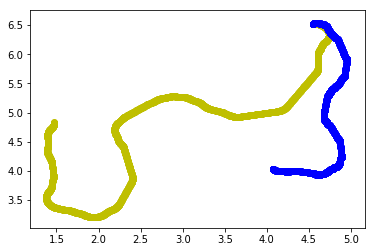

In [12]:
plt.figure()
plt.scatter(odometry_x, odometry_y, c='y')
plt.scatter(ground_truth_x, ground_truth_y, c='b')
plt.show()

# TESTE

## Remove duplicates on lines and corners find at the images

In [32]:
final_lines = []
for p1, p2 in permutations(lines, 2):
    if p1 != p2:
        if p1 not in final_lines:
            final_lines.append(p1)
        if p2 not in final_lines:
            final_lines.append(p2)

In [35]:
final_corners = []
for p1, p2 in permutations(corners, 2):
    if p1 != p2:
        if p1 not in final_corners:
            final_corners.append(p1)
        if p2 not in final_corners:
            final_corners.append(p2)